In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

In [3]:
def create_captcha(text, shear=0, size=(100,24)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"Coval.otf", 22)
    draw.text((2, 2), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()

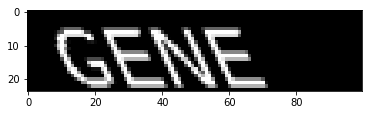

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5)
plt.imshow(image, cmap="gray")

In [5]:
from skimage.measure import label, regionprops

In [6]:
def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

In [7]:
subimages = segment_image(image)

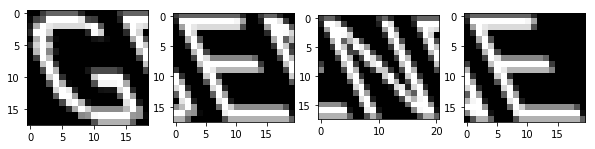

In [8]:
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

In [9]:
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ACBDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

In [10]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20, 20)), letters.index(letter)

The target for this image is: 11


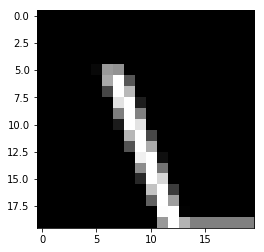

In [11]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="gray")
print("The target for this image is: {0}".format(target))

In [12]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(3000)))
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

In [13]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

C:\Users\quekai\AppData\Roaming\Python\Python35\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [14]:
y = y.todense()

In [15]:
from skimage.transform import resize

In [16]:
dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for
sample in dataset])

C:\Users\quekai\AppData\Roaming\Python\Python35\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\quekai\AppData\Roaming\Python\Python35\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [17]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] *
dataset.shape[2]))

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, train_size=0.9)

C:\Users\quekai\AppData\Roaming\Python\Python35\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [19]:
from pybrain.datasets import SupervisedDataSet

In [20]:
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])

In [21]:
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])

In [22]:
from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

In [23]:
from pybrain.supervised import BackpropTrainer
trainer = BackpropTrainer(net, training, learningrate=0.01, weightdecay=0.01)

In [24]:
trainer.trainEpochs(epochs=20)

In [25]:
predictions = trainer.testOnClassData(dataset=testing)

In [26]:
from sklearn.metrics import f1_score
print("F-score: {0:.2f}".format(f1_score(predictions, y_test.argmax(axis=1), average="micro")))

F-score: 0.96


In [28]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    predicted_word = ""
    for subimage in subimages:
        subimage = resize(subimage, (20, 20))
        outputs = net.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word

In [29]:
word = "GENE"
captcha = create_captcha(word, shear=0.2)
print(predict_captcha(captcha, net))

GENE


In [30]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    return word == prediction, word, prediction

In [33]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\quekai\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [34]:
valid_words = [word.upper() for word in words.words() if len(word) == 4]

In [35]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = test_prediction(word, net, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1

C:\Users\quekai\AppData\Roaming\Python\Python35\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\quekai\AppData\Roaming\Python\Python35\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [36]:
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 3650
Number incorrect is 1863


In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

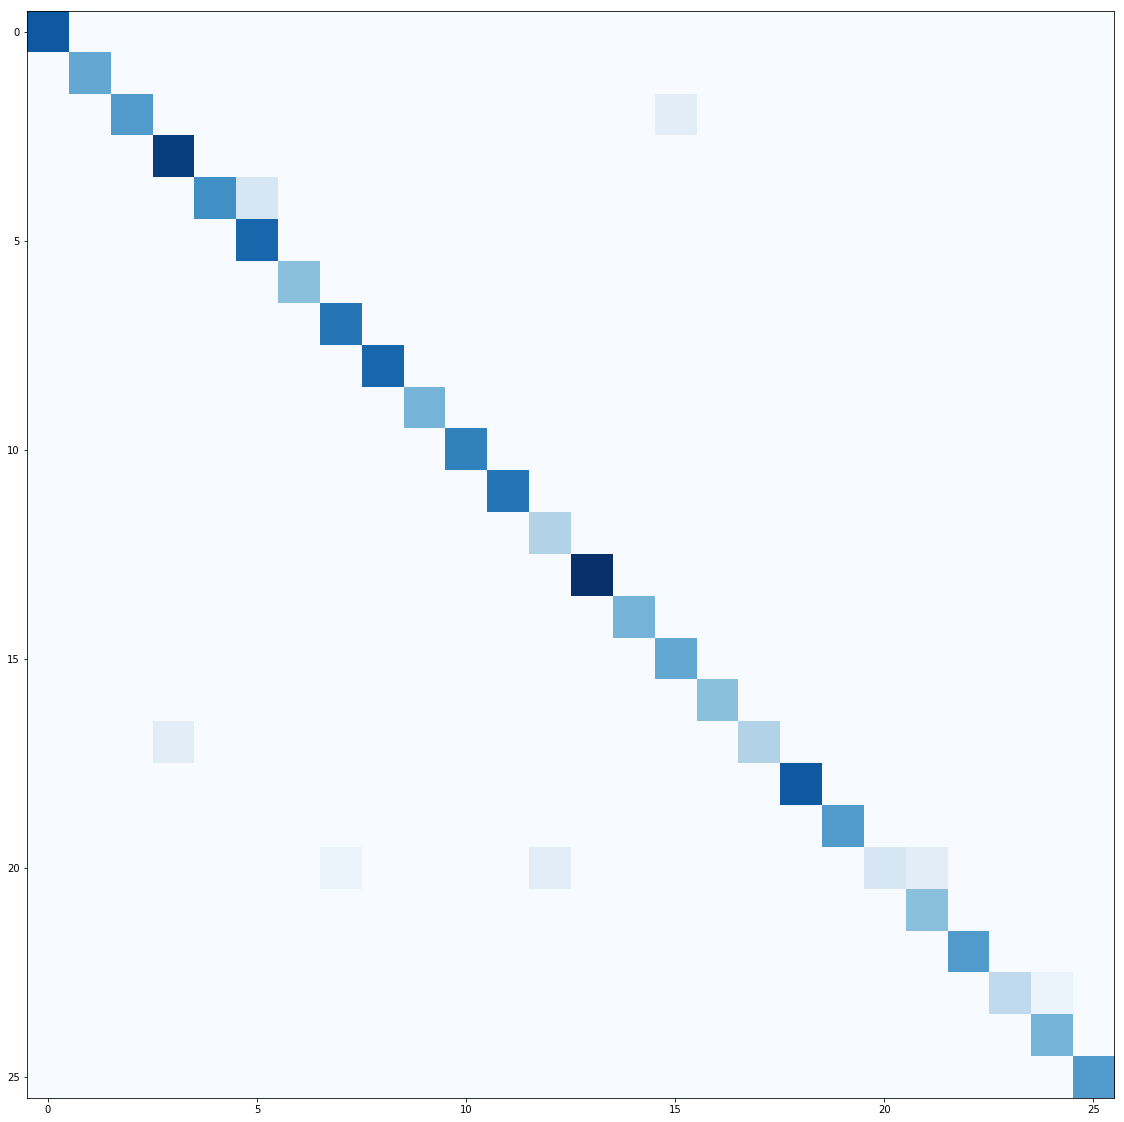

In [38]:
plt.figure(figsize=(20,20))
plt.imshow(cm, cmap="Blues")

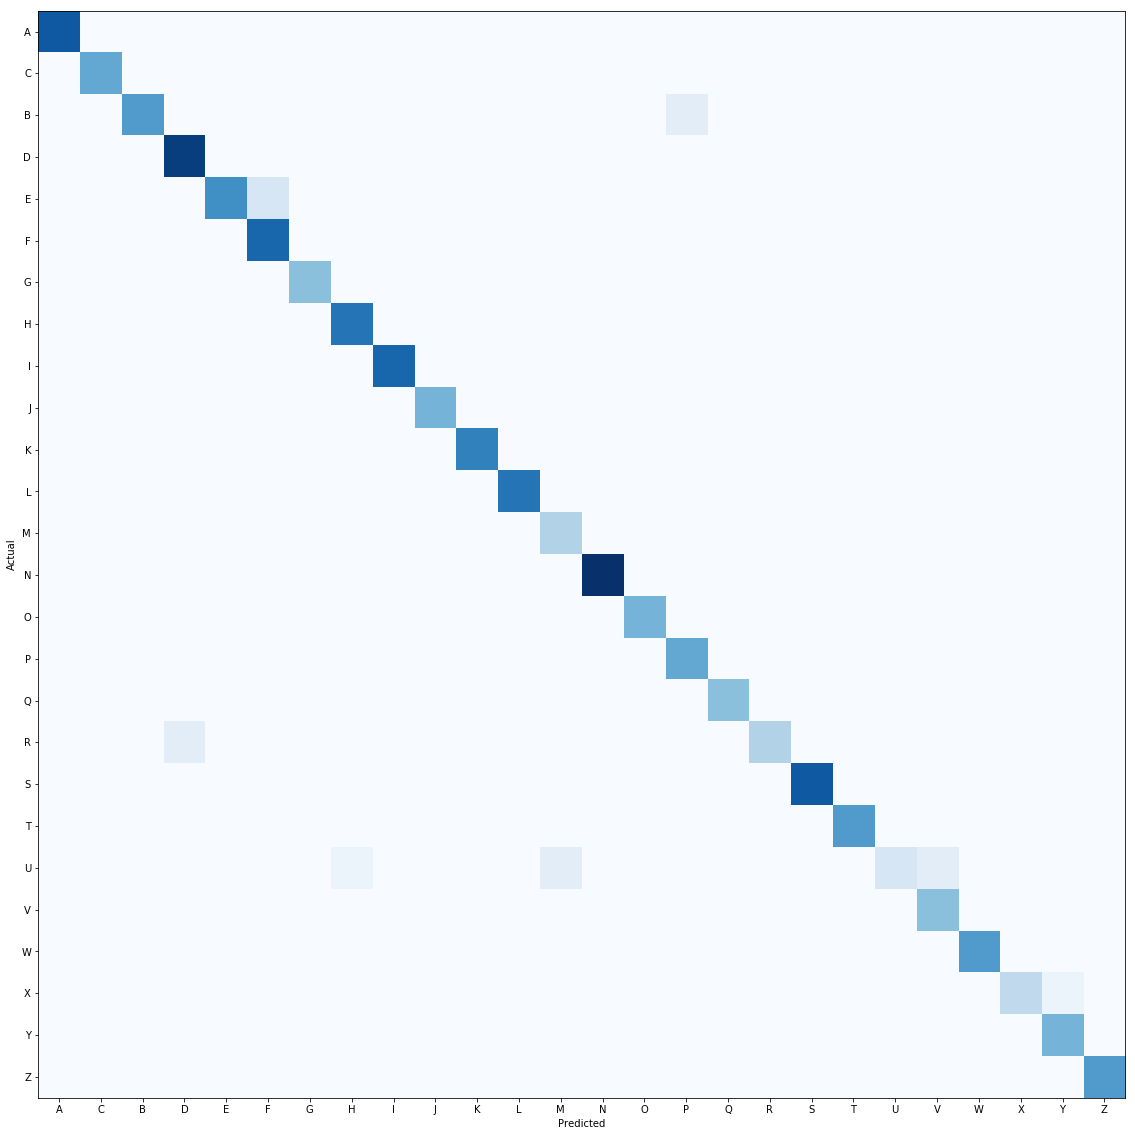

In [42]:
plt.figure(figsize=(20,20))
tick_marks = np.arange(len(letters))
plt.xticks(tick_marks, letters)
plt.yticks(tick_marks, letters)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.imshow(cm, cmap="Blues")

In [43]:
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [44]:
def compute_distance(prediction, word):
    return len(prediction) - sum(prediction[i] == word[i] for i in range(len(prediction)))

In [45]:
from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word))
                            for word in dictionary],
                           key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [46]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = improved_prediction (word, net, valid_words, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

C:\Users\quekai\AppData\Roaming\Python\Python35\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\quekai\AppData\Roaming\Python\Python35\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Number correct is 3784
Number incorrect is 1729
